In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import random
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import preprocessing
import math
from scipy.spatial.distance import euclidean as eu

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

import Data_load as dl
from scipy import signal
from scipy.fftpack import fft, dct

## Intuition
The main problem we need to tackle is the variable lengths of the data. Other approaches involve extraction of a fixed number of features (n), which leads to the same n-dimensional dataset with each dimension representing a feature. This needs a keen understanding of the domain, and still considers many assumptions about the features to be selected. In case of incomplete knowledge of the domain, the feature selection process may miss out on crucial aspects of the signal.
If we were to consider the raw signal for processing, then the process of equalising the lengths includes padding or interpolating data. However, adding information to temporal data can change the significance of the temporal and spectral properties of the signal.

## Frequency Domain
A frequency transform of the time series data is computed, which in most cases, preserves the important information present in the data set. However, the length of the signals differ in the spectral domain as well. We can now make changes to the signal in the frequency domain without changing temporal properties of the signal. To avoid adding points to the signal, we can consider a sliding window over the signal and create groups or bins of frequencies. If we make the same number of bins across the signal, while keeping a fraction of frequencies common between adjacent bins, we can capture defining aspects of the temporal domain without making decisions to include or exclude specific features. With the same number of bins for each signal the final output will be of the same length and can be considered unadulterated data which is compressed to a specific spectral group.


Collecting the data into Dyslexic and Control

In [3]:
feature_list=['LX', 'LY', 'RX', 'RY']
C_data, D_data = dl.get_data()


new_vals() - takes the eye tracking readings from the left and right eye and combines it into a single array of complex numbers

In [4]:
def new_vals(data):
    x = [sum(x) for x in zip(data['LX'].to_list(), data['RX'].tolist())]
    y = [sum(x) for x in zip(data['LY'].to_list(), data['RY'].tolist())]
    
    compl = np.array([complex(a,b) for a,b in zip(x, y)])
    
    return compl

binning() - maps a vector any lenght to a vector of a fixed length(bins) as needed.  This helps to compare vectors of various lengths. Each entry of the resulting vector is a sum of fixed number of elements of the input vector. Few of these elements are considered common for successive entries into the resulting vector. This is the overlapping factor. 


So the fixed number of elements considered for the each entry = (lenght of input vector/lenght of output vector) + overlap

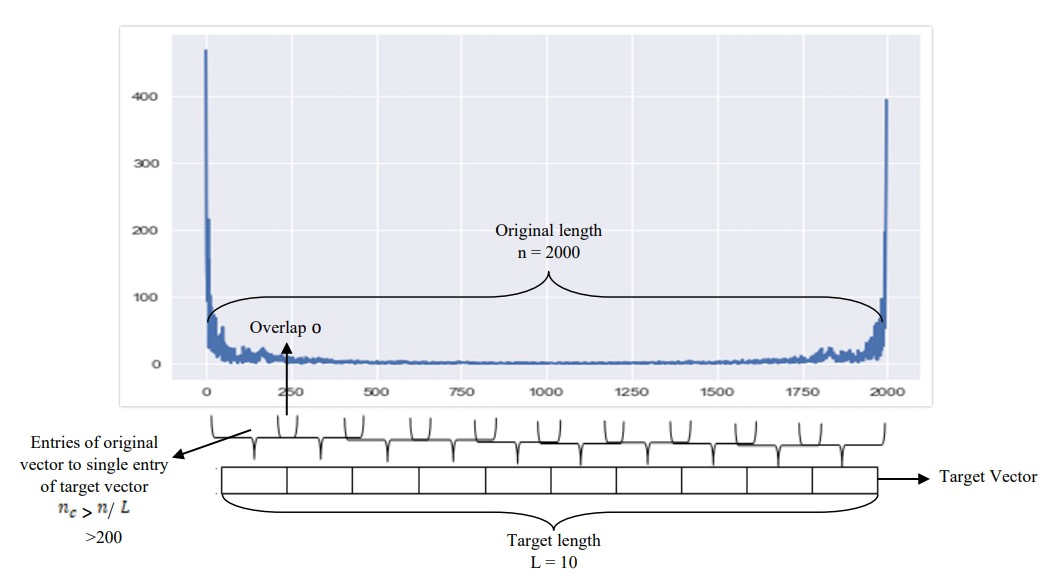


In [5]:
def binning(bins, fft, overlap_per):
    div_size = len(fft)/bins
    bin_size = div_size*(1+(overlap_per/100))
    half_bin = bin_size/2
    
    binned = []
    
    current_step = bin_size
    for a in range(bins):
        
        pos = np.ceil(half_bin + a*(div_size))
        start = 0 if a == 0 else int(np.ceil(pos - half_bin))
        end = -1 if a == (bins-1) else int(np.ceil(pos + half_bin))
        #print([start, end])
        
        binned = np.append(binned, sum(np.abs(fft[start : end]))) 
        
    return binned

kmeans_binning() - kmeans clustering of the binned vectors. 

In [7]:
def kmeans_binning(D_data,C_data, bins, bins_per):
    
    data_sets = [D_data,C_data]
    all_buckets = []
    for dataset in data_sets:
        for no in range(len(dataset)):
            d = new_vals(dataset[no])
            fft = dct(d)   

            binned = binning(bins, fft, bins_per)
            all_buckets.append(binned)
            buckets = np.asarray(all_buckets)
            
    kmeans = KMeans(n_clusters = 2, random_state=0).fit(buckets)
    predicted_labels = kmeans.labels_
    actual_labels = np.concatenate((np.ones(98), np.zeros(88)))
    
    conf_m = confusion_matrix(actual_labels,predicted_labels)[:2]
    acc = accuracy_score(actual_labels,predicted_labels)*100
    
    return buckets

In [8]:
vec = kmeans_binning(D_data,C_data, 1000, 10)

In [12]:
X = np.asarray(vec)

In [13]:
y= np.concatenate((np.ones(88), np.zeros(98)))

In [11]:
vals1 = np.load('accuracy_vals.npy')

In [14]:
from sklearn.linear_model import Perceptron
clf = Perceptron(tol=1e-3, random_state=0)

In [16]:
clf.fit(X, y)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
clf.score(X, y)

0.7258064516129032